In [3]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import pandas as pd
import os
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from bag_of_words import ParseData
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Conferences
conf = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

# JSON files to be parsed
dir_path    = '../PeerRead/data/'
train_path  = '/train/reviews/'
test_path   = '/test/reviews/'

In [5]:
tf_idf = ParseData()

# json_train_files = sorted([pos_json for pos_json in os.listdir(acl_train_path) if pos_json.endswith('.json')])
# json_test_files = sorted([pos_json for pos_json in os.listdir(acl_test_path) if pos_json.endswith('.json')])
json_train_files    = []
json_test_files     = []
N_training          = 0
N_testing           = 0
for c in conf:
    c_train_path    = dir_path + c + train_path
    c_test_path     = dir_path + c + test_path
    c_json_train    = sorted([pos_json for pos_json in os.listdir(c_train_path) if pos_json.endswith('.json')])
    c_json_test     = sorted([pos_json for pos_json in os.listdir(c_test_path) if pos_json.endswith('.json')])
    c_json_train    = [c_train_path + s for s in c_json_train]
    c_json_test     = [c_test_path + s for s in c_json_test]
    json_train_files.append(c_json_train)
    json_test_files.append(c_json_test)
    N_training += len(c_json_train)
    N_testing += len(c_json_test)

In [6]:
# Creating the dataset in string format
train_data  = []
test_data   = []
train_title = []
test_title  = []

for c in json_train_files:
    title, data = tf_idf.parse_json_files(c)
    train_data.extend(data)
    train_title.extend(title)

for c in json_test_files:
    title, data = tf_idf.parse_json_files(c)
    test_data.extend(data)
    test_title.extend(title)

merged_data = []
merged_data.extend(train_data)
merged_data.extend(test_data)

In [7]:
# Getting bag of words data structure
CountVec = CountVectorizer(ngram_range=(1,1), preprocessor=tf_idf.preprocess_text, stop_words='english')
Count_data = CountVec.fit_transform(merged_data)
X_train = X[0:len(train_data)]
X_test = X[len(train_data):]
# print(CountVec.get_feature_names())
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()])
# print(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()].iloc[:, : 10].to_markdown())
# print(cv_dataframe)

NameError: name 'X' is not defined

KMeans(max_iter=1000, n_clusters=6)

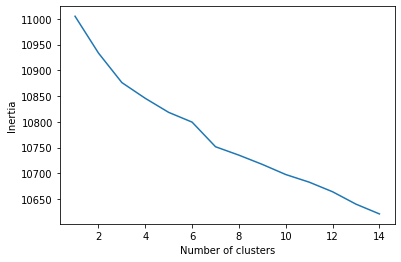

In [121]:
# Cluster documents based on BOW model
bow_distortions = []
K = range(1,15)

for k in K:
    bow_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bow_model.fit(X_train)
    bow_distortions.append(bow_model.inertia_)

plt.plot(K, bow_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bow_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bow_model.fit(X_train)

Top terms per cluster:


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


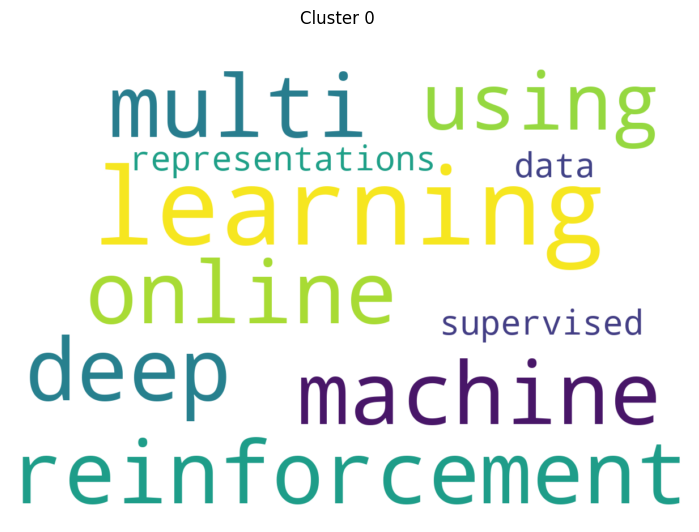

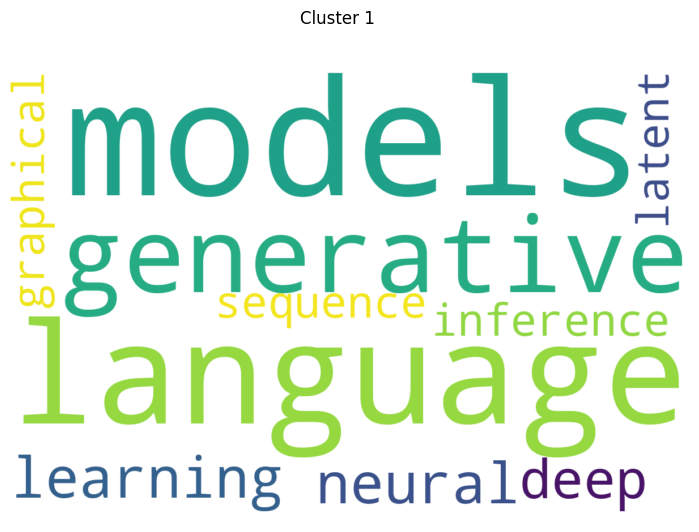

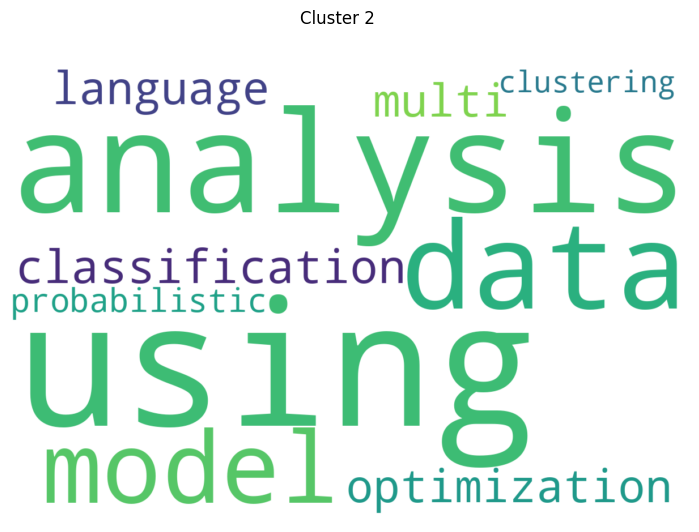

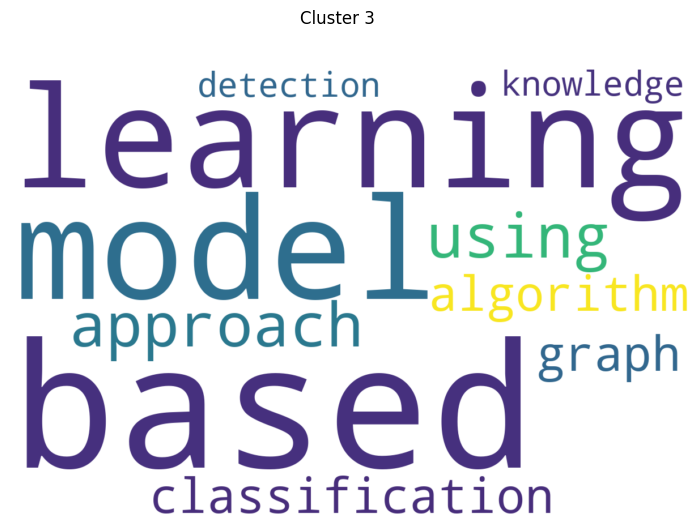

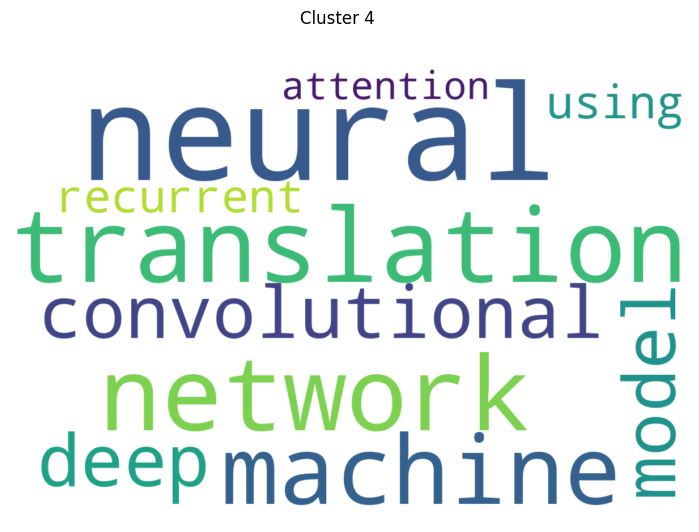

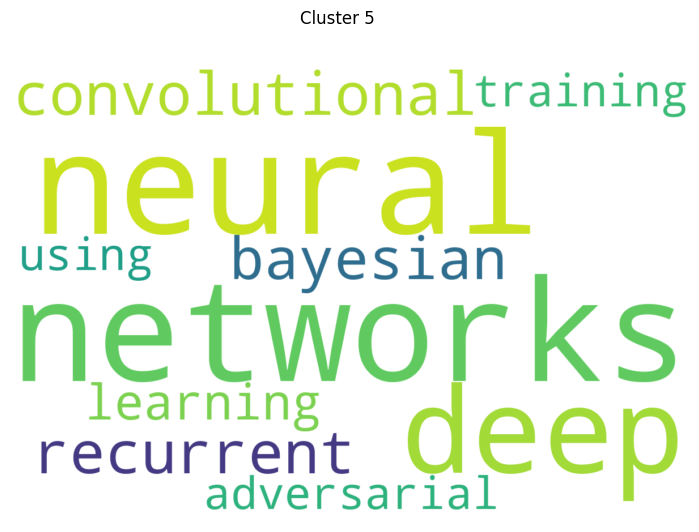

In [122]:
# Print top terms per cluster and generate word clouds for BOW model
print("Top terms per cluster:")
bow_order_centroids = bow_model.cluster_centers_.argsort()[:, ::-1]
terms = CountVec.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bow_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [123]:
# Testing the Clustering based on BOW model
# Predict the cluster association of each paper

prediction = bow_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            2 |
|  1 | A Neural Local Coherence Model                                                                     |            4 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            3 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            4 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

In [12]:
# Getting tf-idf data structure
# Vectorize the text
vectorizer = TfidfVectorizer(preprocessor=tf_idf.preprocess_text, stop_words='english')
X = vectorizer.fit_transform(merged_data)
X_train = X[0:len(train_data)]
X_test = X[len(train_data):]
tf_idf_df=pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names_out())
display(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()])
print(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()].iloc[:, : 10].to_markdown())

,annotation,answering,attention,base,based,bridge,cross,detection,effective,embedding,...,overlapping,projection,prototype,question,recognition,relation,representation,supervised,text,weakly
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.467153,0.000000,0.000000,0.000000,0.299487,...,0.000000,0.000000,0.442089,0.00000,0.000000,0.000000,0.000000,0.000000,0.258115,0.00000
1,0.000000,0.00000,0.318779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.330864,0.00000,0.000000,0.000000,0.000000,0.000000,0.286734,0.000000,0.330864,0.000000,...,0.000000,0.335106,0.000000,0.00000,0.227005,0.000000,0.252395,0.250016,0.000000,0.34673
3,0.000000,0.00000,0.000000,0.000000,0.215444,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.557273,0.000000,0.000000,0.00000,0.288827,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.36217,0.000000,0.429501,0.000000,0.000000,0.000000,0.306265,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.36217,0.000000,0.405613,0.000000,0.000000,0.000000,0.00000


|    |   annotation |   answering |   attention |     base |    based |   bridge |    cross |   detection |   effective |   embedding |
|---:|-------------:|------------:|------------:|---------:|---------:|---------:|---------:|------------:|------------:|------------:|
|  0 |     0        |     0       |    0        | 0        | 0        | 0.467153 | 0        |    0        |    0        |    0.299487 |
|  1 |     0        |     0       |    0.318779 | 0        | 0        | 0        | 0        |    0        |    0        |    0        |
|  2 |     0.330864 |     0       |    0        | 0        | 0        | 0        | 0.286734 |    0        |    0.330864 |    0        |
|  3 |     0        |     0       |    0        | 0        | 0.215444 | 0        | 0        |    0        |    0        |    0        |
|  4 |     0        |     0.36217 |    0        | 0.429501 | 0        | 0        | 0        |    0.306265 |    0        |    0        |


In [13]:
# Dimension reduction on TF-IDF using SVD
svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = svd.fit_transform(X)
X_train = X_new[0:len(train_data)]
X_test = X_new[len(train_data):]

KMeans(max_iter=1000, n_clusters=6)

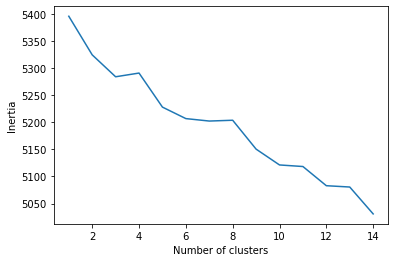

In [14]:
# cluster documents based on tf-idf scores
distortions = []
K = range(1,15)

for k in K:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    model.fit(X_train)
    distortions.append(model.inertia_)

plt.plot(K, distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
model.fit(X_train)

Top terms per cluster:


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


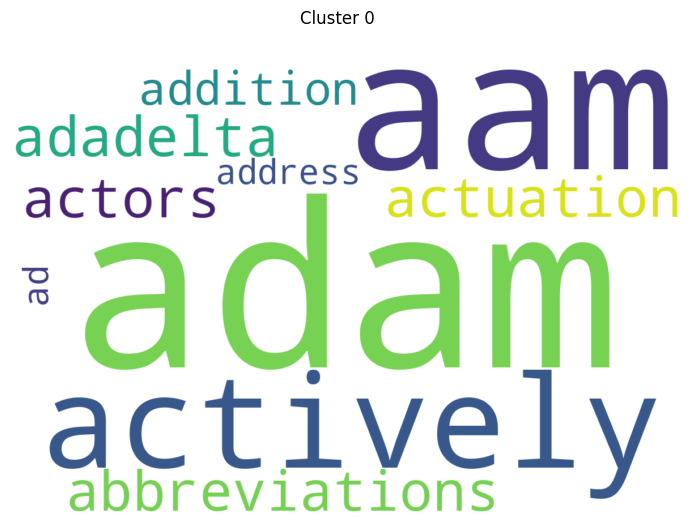

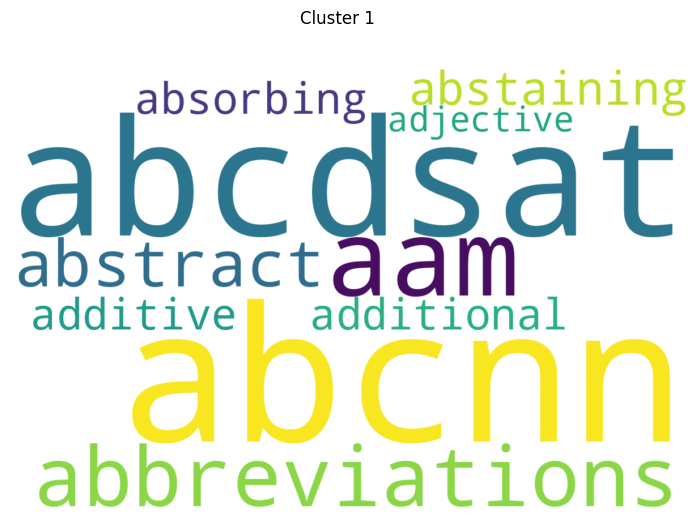

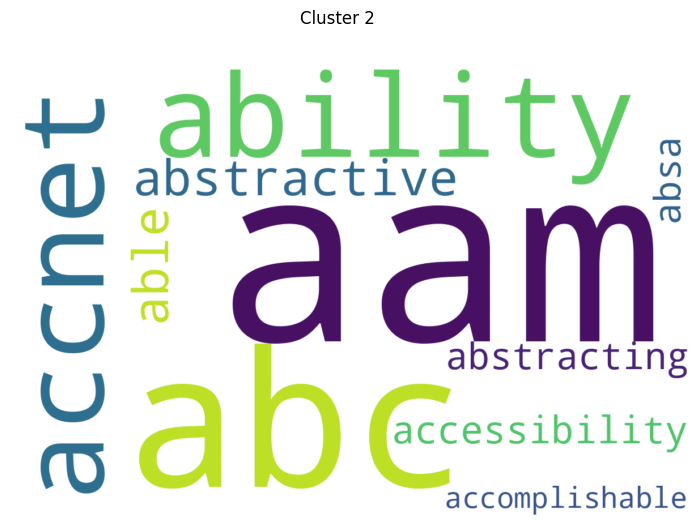

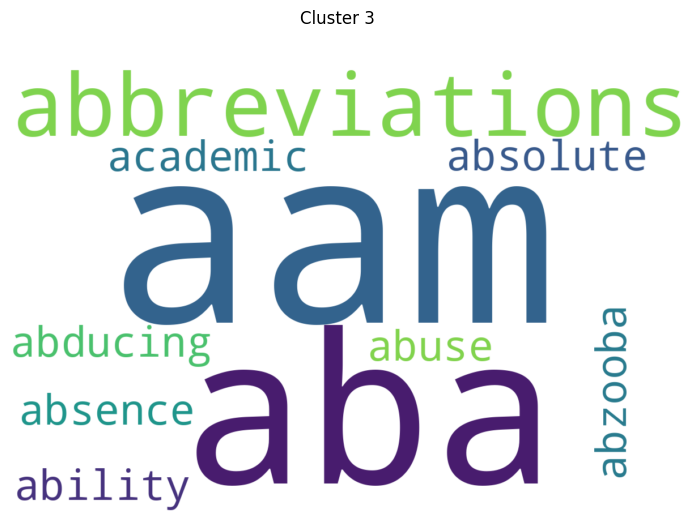

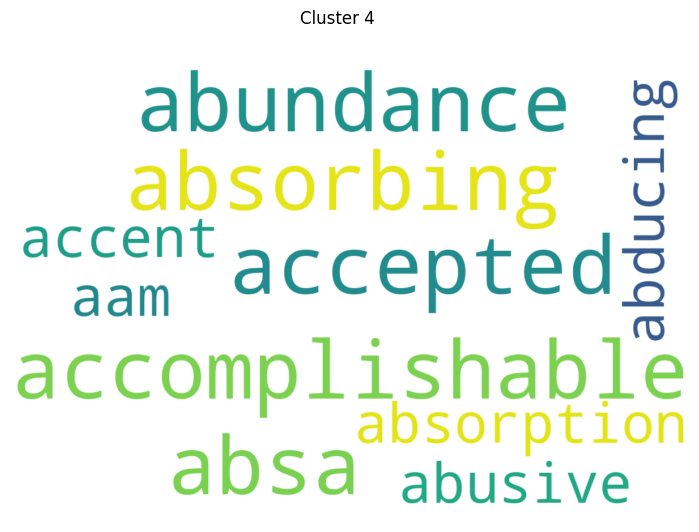

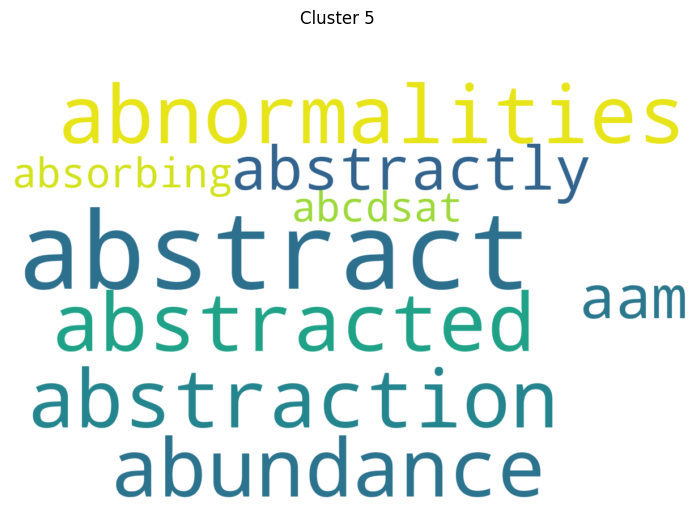

In [15]:
# Print top terms per cluster and generate word clouds
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [124]:
# Testing the Model
# Predict the cluster association of each paper
prediction = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            0 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            0 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            0 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

KMeans(max_iter=1000, n_clusters=6)

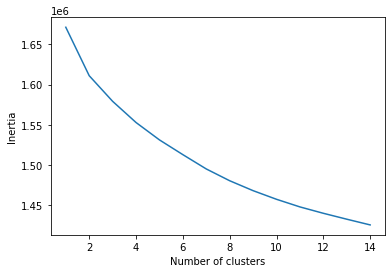

In [127]:
# BERT Encoding using SentenceTransformer and pre-trained distillbert model

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings = embedder.encode(merged_data)

X_train = embeddings[0:len(train_data)]
X_test = embeddings[len(train_data):]

# K-means clustering on BERT encoding

bert_distortions = []
K = range(1,15)
for k in K:
    bert_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bert_model.fit(X_train)
    bert_distortions.append(bert_model.inertia_)

plt.plot(K, bert_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bert_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bert_model.fit(X_train)

In [132]:
# Print top terms per cluster and generate word clouds for BERT model
print("Top terms per cluster:")
bert_order_centroids = bert_model.cluster_centers_.argsort()[:, ::-1]
terms = embeddings.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bert_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

Top terms per cluster:
[-2.44336024e-01  3.19006532e-01  6.69736147e-01  4.97103371e-02
  2.52878666e-01 -3.50588948e-01  2.74452806e-01 -2.81808794e-01
 -7.81178847e-02 -1.17719638e+00  3.61000821e-02  1.08183727e-01
 -5.04054248e-01  4.83691990e-01 -1.20384470e-02  2.33392090e-01
  1.92506880e-01 -3.42532665e-01 -3.88909757e-01 -7.58971646e-03
  1.00764680e+00  1.82239145e-01 -5.99580169e-01  6.03163004e-01
  6.44917488e-01  3.04467976e-01  9.56178188e-01  1.59884858e+00
  1.46052256e-01  4.39293906e-02  6.83978975e-01 -4.89296734e-01
  4.52408940e-02 -1.15880445e-01 -7.68973827e-02 -1.16302287e-02
  4.19114262e-01 -8.13783288e-01 -2.54536241e-01  1.51119933e-01
  2.77184099e-01  1.86565071e-01  1.32472634e-01  3.66769135e-01
 -3.34384531e-01 -1.43240497e-01 -9.17086542e-01  3.53527576e-01
 -1.35454488e+00  4.73264419e-02 -9.60772276e-01 -5.69244176e-02
  1.41296372e-01 -4.78532195e-01 -7.17547297e-01 -4.29592952e-02
 -5.49104810e-01 -1.22804776e-01  1.47263253e+00  1.11831546e-01
 -

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [129]:
# Predict the clusters using BERT encoded model
bert_prediction = bert_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
bert_df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(bert_df.head(10).loc[:,bert_df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 768)
(637, 768)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            0 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            0 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            0 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |        